# Nodal tide estimation based on a global tidal model 

## Introduction
This notebook is the analysis of GTSM nodal tide reanalysis run. In this run we simulate 19 years of just tidal forcing. The main research question is how does the nodal tide, the 18.613 cycle, affect the mean sea level and the tidal range. 

We use the following model run.
- Schematization: GTSMv3.0EMODnet
- Bathymetry: EMODnet2020
- Run: production_runs_2021 (No Wind, No Waves, All tidal constituents active)
- Runtime 1999-2017

**Script author:** n-aleksandrova, adapted based on [work by Fedor Baart](https://github.com/openearth/sealevel/blob/report/notebooks/analysis/gtsm/nodal-tide.ipynb) in the original SeaLevelMonitor repository



To run this notebook you need a Python environment that includes [dfm_tools](https://github.com/Deltares/dfm_tools) and [statsmodels](https://pypi.org/project/statsmodels/), both installable via pip.

## Load libraries

In [ ]:
import pathlib
import datetime

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import statsmodels.api as sm

import dfm_tools as dfmt

## Load necessary data

Location of the GTSMv3.0 runs performed for the EMODnet project, tide-only for 1999-2017:

In [2]:
data_dir = pathlib.Path(r'p:\1230882-emodnet_hrsm\GTSMv3.0EMODnet\EMODnet2020\production_runs_2021\sealevel_data')
data_dir

WindowsPath('p:/1230882-emodnet_hrsm/GTSMv3.0EMODnet/EMODnet2020/production_runs_2021/sealevel_data')

### Loading water level statistics

Loading statistics derived from the 1999-2017 GTSM runs - monthly means, year means, year max and year min for a subset of GTSM observation stations (>4200 globally).

In [3]:
ds_yearstats = xr.open_mfdataset(str(data_dir / "EM_*_YEARMEAN_his.nc"), combine="by_coords", data_vars='all')
ds_yearstats = ds_yearstats[['waterlevel']]
ds_yearstats = ds_yearstats.rename({'waterlevel' : 'waterlevel_mean'})

ds_max = xr.open_mfdataset(str(data_dir / "EM_*_YEARMAX_his.nc"), combine="by_coords", data_vars='all')
ds_yearstats['waterlevel_max'] = ds_max['waterlevel']
ds_max.close(); del ds_max

ds_min = xr.open_mfdataset(str(data_dir / "EM_*_YEARMIN_his.nc"), combine="by_coords", data_vars='all')
ds_yearstats['waterlevel_min'] = ds_min['waterlevel']
ds_min.close(); del ds_min

ds_yearstats['stations'] = (('stations'), ds_yearstats.stations.values)
ds_yearstats

<xarray.Dataset> Size: 2MB
Dimensions:               (time: 19, stations: 4204)
Coordinates:
  * time                  (time) datetime64[ns] 152B 1999-07-02T11:55:00 ... ...
    station_x_coordinate  (stations) float64 34kB dask.array<chunksize=(4204,), meta=np.ndarray>
    station_y_coordinate  (stations) float64 34kB dask.array<chunksize=(4204,), meta=np.ndarray>
  * stations              (stations) int64 34kB 0 1 2 3 ... 4200 4201 4202 4203
Data variables:
    waterlevel_mean       (time, stations) float64 639kB dask.array<chunksize=(1, 4204), meta=np.ndarray>
    waterlevel_max        (time, stations) float64 639kB dask.array<chunksize=(1, 4204), meta=np.ndarray>
    waterlevel_min        (time, stations) float64 639kB dask.array<chunksize=(1, 4204), meta=np.ndarray>
Attributes:
    CDI:            Climate Data Interface version 1.9.5 (http://mpimet.mpg.d...
    Conventions:    CF-1.5 Deltares-0.1
    history:        Tue Mar 23 13:04:21 2021: cdo -L -yearmean -selyear,1999 ...
    source:         Deltares, D-Flow FM Version 1.2.104.67831M, Oct 28 2020, ...
    institution:    Deltares
    references:     http://www.deltares.nl
    date_created:   2021-03-15T13:17:56+0100
    date_modified:  2021-03-15T13:17:56+0100
    frequency:      year
    CDO:            Climate Data Operators version 1.9.5 (http://mpimet.mpg.d...

In [4]:
ds_monmean = xr.open_mfdataset(str(data_dir / "EM_*_MONMEAN_his.nc"), combine="by_coords", data_vars='all')
ds_monmean = ds_monmean[['waterlevel']]

ds_monmean = ds_monmean.rename({'waterlevel' : 'waterlevel_mean'})

ds_monmean['stations'] = (('stations'), ds_monmean.stations.values)

### Loading station names and waterdepth

Retrieve station names from hisfile sample:

In [5]:
file_his = data_dir / "EM_19990101_0000_short_his.nc"

nc_his = xr.open_dataset(file_his)
nc_his

<xarray.Dataset> Size: 47MB
Dimensions:                               (nFlowElemWithBnd: 225038,
                                           nFlowElemContourPts: 4,
                                           nNetLink: 429999, nNetLinkPts: 2,
                                           nFlowLink: 417800, nFlowLinkPts: 2,
                                           stations: 4204,
                                           station_geom_nNodes: 4204, time: 3)
Coordinates:
    station_x_coordinate                  (stations) float64 34kB ...
    station_y_coordinate                  (stations) float64 34kB ...
    station_name                          (stations) |S64 269kB ...
  * time                                  (time) datetime64[ns] 24B 1998-12-1...
Dimensions without coordinates: nFlowElemWithBnd, nFlowElemContourPts,
                                nNetLink, nNetLinkPts, nFlowLink, nFlowLinkPts,
                                stations, station_geom_nNodes
Data variables: (12/66)
    FlowElem_xcc                          (nFlowElemWithBnd) float64 2MB ...
    FlowElem_ycc                          (nFlowElemWithBnd) float64 2MB ...
    FlowElem_zcc                          (nFlowElemWithBnd) float64 2MB ...
    FlowElem_bac                          (nFlowElemWithBnd) float64 2MB ...
    FlowElem_xzw                          (nFlowElemWithBnd) float64 2MB ...
    FlowElem_yzw                          (nFlowElemWithBnd) float64 2MB ...
    ...                                    ...
    water_balance_Qext_out_1D             (time) float64 24B ...
    water_balance_Qext_total_1D           (time) float64 24B ...
    water_balance_Qext_in_2D              (time) float64 24B ...
    water_balance_Qext_out_2D             (time) float64 24B ...
    water_balance_Qext_total_2D           (time) float64 24B ...
    timestep                              (time) float64 24B ...
Attributes:
    institution:    Deltares
    references:     http://www.deltares.nl
    source:         Deltares, D-Flow FM Version 1.2.104.67831M, Oct 28 2020, ...
    history:        Created on 2021-03-25T17:47:12+0100, D-Flow FM
    date_created:   2021-03-25T17:47:12+0100
    date_modified:  2021-03-25T17:47:12+0100
    Conventions:    CF-1.5 Deltares-0.1

In [6]:
ds_yearstats['bedlevel'] = nc_his['bedlevel']

In [7]:
stationnames = nc_his['station_name'].load().str.decode('utf-8',errors='ignore').str.strip()
stationnames

<xarray.DataArray 'station_name' (stations: 4204)> Size: 673kB
array(['arctic_ocean_xm155_y75', 'arctic_ocean_xm145_y75',
       'arctic_ocean_xm135_y75', ..., 'psmsl-2358', 'psmsl-2359',
       'psmsl-2360'], shape=(4204,), dtype='<U40')
Coordinates:
    station_x_coordinate  (stations) float64 34kB -155.0 -145.0 ... 16.96 11.83
    station_y_coordinate  (stations) float64 34kB 75.0 75.0 75.0 ... 58.48 58.15
    station_name          (stations) |S64 269kB b'arctic_ocean_xm155_y75' ......
Dimensions without coordinates: stations

In [8]:
stations_pd = pd.DataFrame({'stations': stationnames.values})
stations_pd

,stations
0,arctic_ocean_xm155_y75
1,arctic_ocean_xm145_y75
2,arctic_ocean_xm135_y75
3,arctic_ocean_xm5_y75
4,arctic_ocean_x5_y75
...,...
4199,psmsl-2354
4200,psmsl-2356
4201,psmsl-2358
4202,psmsl-2359


In [9]:
ds_yearstats['station_name'] = nc_his['station_name'].load().str.decode('utf-8',errors='ignore').str.strip()

## Inspect the data

First checking which years are available:

In [10]:
dates = ds_yearstats.waterlevel_mean.time.values.astype("M8[ms]").astype("O")

year = np.array([x.year for x in dates], dtype="double")

assert np.allclose(np.diff(year), 1), f"all years should be sequential: {year}"
# show all the years
year

array([1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006., 2007.,
       2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015., 2016.,
       2017.])

Inspect the locations of the data points:


>> reading coastlines: 2.62 sec


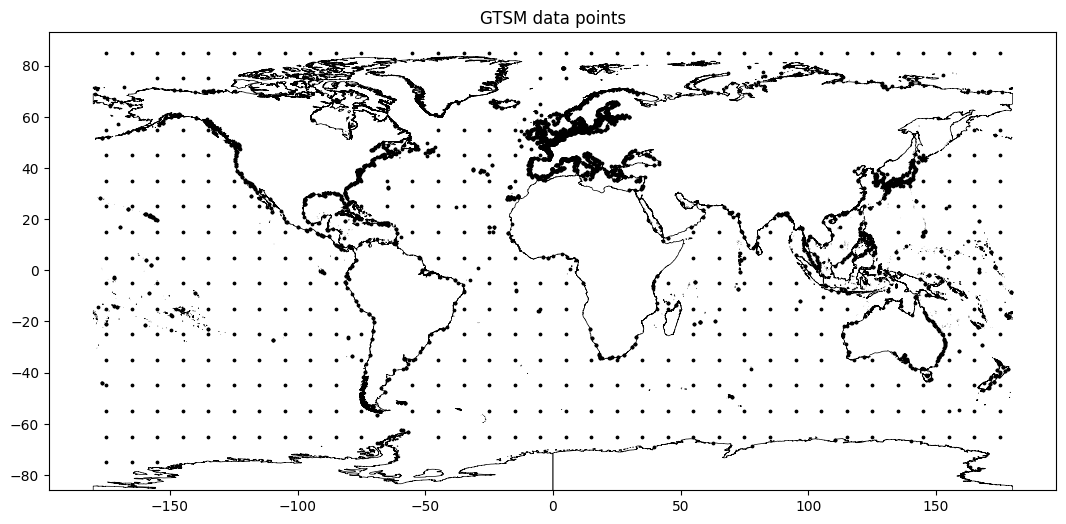

In [11]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.set_title("GTSM data points")
sc = ax.scatter(ds_yearstats.station_x_coordinate.values, 
                ds_yearstats.station_y_coordinate.values, 
                c='k', s=3)
dfmt.plot_coastlines(ax=ax)

The presence of the observation data points is denser at higher latitudes (more stations in areas where more tidal gauge observations are available, since this set of stations is partly based on PSMSL and CMEMS tide gauge coordinates). This can be demonstrated as a historgram of number of observation points across latitudes:

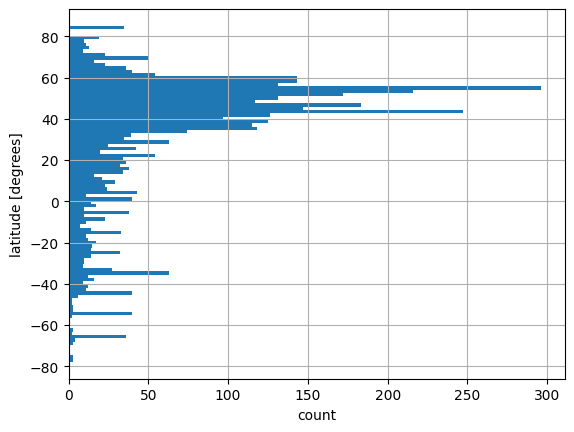

In [12]:
# Using the PSMSL and EU stations gives a skewness towards higher latitudes
fig, ax = plt.subplots()
ax.hist(ds_yearstats.station_y_coordinate.values, bins=100, orientation="horizontal")
ax.set_xlabel("count")
ax.set_ylabel("latitude [degrees]")
ax.grid()

We can inspect the monthly and year means data from GTSM to see if it indeed contains a nodal tide signal. For this we will pick a station close to Hoek van Holland in the Netherlands:

In [13]:
bbox = [4.0382,51.9307,4.8625,52.9086]

ds_sel = ds_yearstats.where((ds_yearstats.station_x_coordinate.load() > bbox[0]) &
                            (ds_yearstats.station_x_coordinate.load() < bbox[2]) &
                            (ds_yearstats.station_y_coordinate.load() > bbox[1]) &
                            (ds_yearstats.station_y_coordinate.load() < bbox[3]), drop=True)
ds_sel

<xarray.Dataset> Size: 16kB
Dimensions:               (time: 19, stations: 24)
Coordinates:
  * time                  (time) datetime64[ns] 152B 1999-07-02T11:55:00 ... ...
    station_x_coordinate  (stations) float64 192B 4.109 4.519 ... 4.109 4.548
    station_y_coordinate  (stations) float64 192B 51.99 52.46 ... 51.99 52.46
  * stations              (stations) int64 192B 1343 1348 1349 ... 2714 2724
    station_name          (stations) <U40 4kB 'NWS_NO_TS_MO_HoekVanHolland' ....
Data variables:
    waterlevel_mean       (time, stations) float64 4kB dask.array<chunksize=(1, 24), meta=np.ndarray>
    waterlevel_max        (time, stations) float64 4kB dask.array<chunksize=(1, 24), meta=np.ndarray>
    waterlevel_min        (time, stations) float64 4kB dask.array<chunksize=(1, 24), meta=np.ndarray>
    bedlevel              (stations) float64 192B -6.441 -20.94 ... -11.82
Attributes:
    CDI:            Climate Data Interface version 1.9.5 (http://mpimet.mpg.d...
    Conventions:    CF-1.5 Deltares-0.1
    history:        Tue Mar 23 13:04:21 2021: cdo -L -yearmean -selyear,1999 ...
    source:         Deltares, D-Flow FM Version 1.2.104.67831M, Oct 28 2020, ...
    institution:    Deltares
    references:     http://www.deltares.nl
    date_created:   2021-03-15T13:17:56+0100
    date_modified:  2021-03-15T13:17:56+0100
    frequency:      year
    CDO:            Climate Data Operators version 1.9.5 (http://mpimet.mpg.d...


Notes from previous analysis:
- there seems to be something wrong for 2014 and 2015 (visible in yearmean and yearmax)
- December data for monthly means is off, this might be because the spinup in december of the previous year is included in the monthly mean (although this should not be the case)
- yearmin shows a non-nodal pattern

In [14]:
cmap = plt.get_cmap("tab10")
colors = [cmap(i) for i in range(10)]

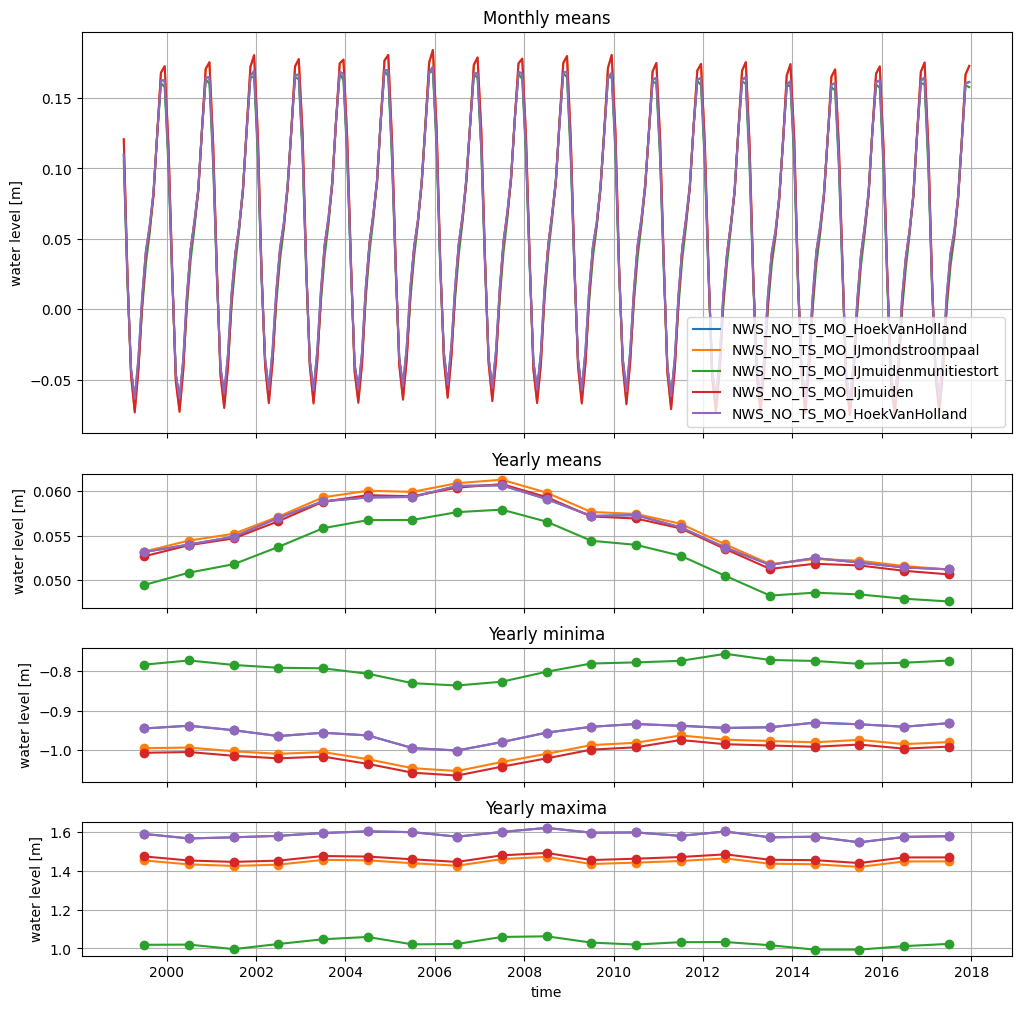

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    4, 1, figsize=(12, 12), gridspec_kw={"height_ratios": [3, 1, 1, 1]}, sharex=True
)

for ss, st_id in enumerate(ds_sel.stations.values[:5]):
    ds_monmean["waterlevel_mean"].sel(stations=st_id).plot.line(x='time', 
                                                                color=colors[ss], 
                                                                label=ds_sel.sel(stations=st_id).station_name.values, 
                                                                ax=ax1)

    ds_sel["waterlevel_mean"].sel(stations=st_id).plot.line(x='time', 
                                                            color=colors[ss],
                                                            ax=ax2,
                                                            marker='o')
    
    ds_sel["waterlevel_min"].sel(stations=st_id).plot.line(x='time', 
                                                            color=colors[ss],
                                                            ax=ax3,
                                                            marker='o')
    
    ds_sel["waterlevel_max"].sel(stations=st_id).plot.line(x='time', 
                                                            color=colors[ss],
                                                            ax=ax4,
                                                            marker='o')
    
ax1.set_title('Monthly means')
ax1.set_xlabel('')
ax2.set_title('Yearly means')
ax2.set_xlabel('')
ax3.set_title('Yearly minima')
ax3.set_xlabel('')
ax4.set_title('Yearly maxima')
ax1.legend(loc=0)
for ax in (ax1, ax2, ax3, ax4):
    ax.grid()


## Deriving nodal tide amplitude and phase
We will analyse the mean sea levels and derive the characteristics of the nodal tide. For this we will use a simple [harmonic fit](https://www.researchgate.net/profile/Phajm-Gelder/publication/236019217_The_Effect_of_the_186-Year_Lunar_Nodal_Cycle_on_Regional_Sea-Level_Rise_Estimates/links/0deec533fc3c070917000000/The-Effect-of-the-186-Year-Lunar-Nodal-Cycle-on-Regional-Sea-Level-Rise-Estimates.pdf) where we include two linearized components for the nodal tide and a constant sea-level. Using this harmonic fit we estimate the phase, amplitude and mean sea level using an ordinary least squared regression fit. From this fit, we can compute the phase and amplitude per station. 



### Check mean sea level
First we check if the mean water level over the entire 1999-2017 period is approximately 0.  

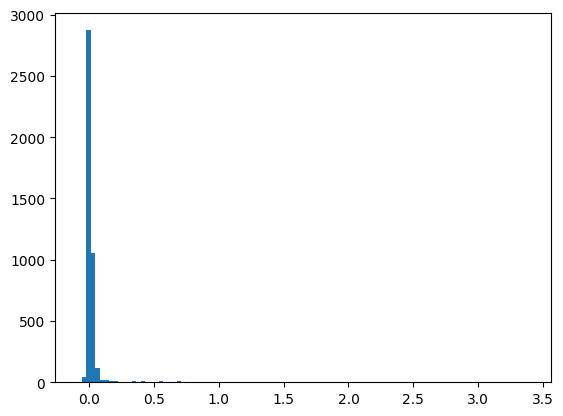

In [16]:
# Check exeptional waterlevels
mean_waterlevel = np.nanmean(ds_yearstats.waterlevel_mean.values, axis=0)
plt.hist(mean_waterlevel, bins=100);

There are some points with significantly higher mean values, we can inspect these more in detail by focusing on mean water levels above 0.1:

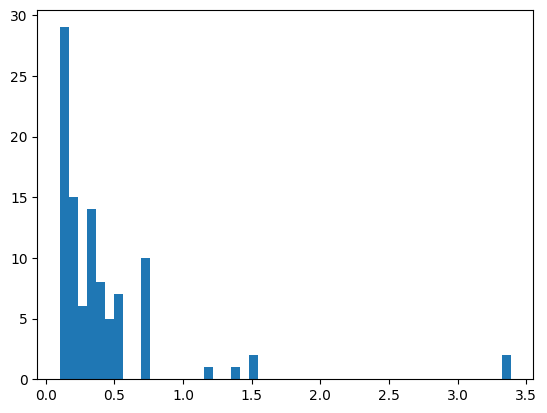

In [17]:
plt.hist(mean_waterlevel[mean_waterlevel>0.1], bins=50);

In [18]:
print(len(mean_waterlevel[mean_waterlevel>0.1]))

100


We will check where these outliers are located:

In [19]:
outliers = ds_yearstats.where(ds_yearstats['waterlevel_mean'].mean("time").load()>0.1, drop=True)

The plot below shows that they are located in narrow estuaries, which are probably not well resolved by the model:

>> reading coastlines: 1.25 sec
>> reading coastlines: 1.18 sec


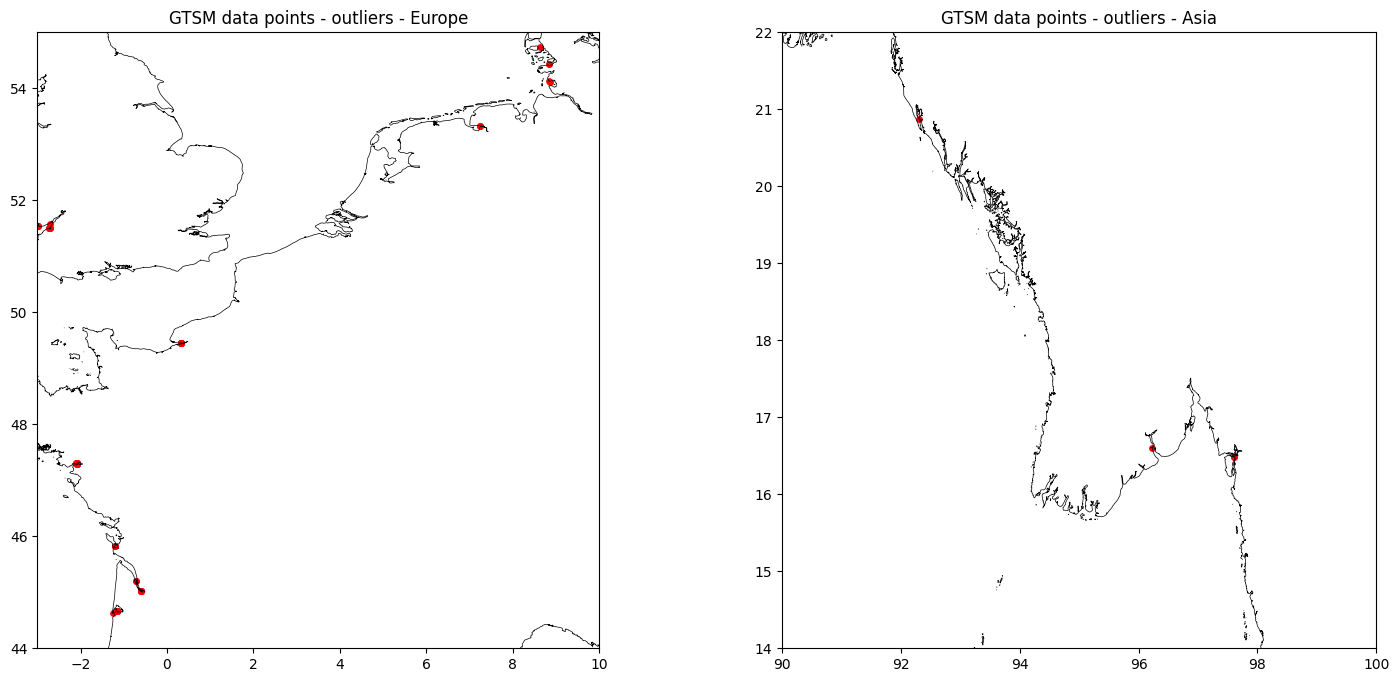

In [20]:
fig, (ax1, ax2) = plt.subplots(figsize=(18, 8), ncols=2)
ax1.set_title("GTSM data points - outliers - Europe")
sc = ax1.scatter(outliers.station_x_coordinate.values, 
                outliers.station_y_coordinate.values, 
                c='r', s=15)
ax1.set_xlim([-3, 10])
ax1.set_ylim([44, 55])
dfmt.plot_coastlines(ax=ax1)

ax2.set_title("GTSM data points - outliers - Asia")
sc = ax2.scatter(outliers.station_x_coordinate.values, 
                outliers.station_y_coordinate.values, 
                c='r', s=15)
ax2.set_xlim([90, 100])
ax2.set_ylim([14, 22])
dfmt.plot_coastlines(ax=ax2)

We will exclude these points from the further analysis:

In [21]:
ds_yearstats = ds_yearstats.where(ds_yearstats['waterlevel_mean'].mean("time").load()<0.1, drop=True)
ds_monmean = ds_monmean.where(ds_yearstats['waterlevel_mean'].mean("time").load()<0.1, drop=True)

### Define model for fitting the nodal tide

In [22]:
tidal_components = pd.read_json("tidal-components.json")
tidal_components = tidal_components.set_index("name_cartwright")
epoch_N = datetime.datetime.fromisoformat(tidal_components.loc["$N$"].epoch)
tidal_components

,phase,period,epoch,name_doodson
name_cartwright,,,,
$\tau$,-111.763459,347.809251,1999-12-31 16:17:16.613,$\tau$
$q$,211.737425,13.176396,2000-01-17 01:40:00.354,$s$
$q'$,279.973966,0.985647,2000-10-11 01:13:13.078,$h$
$p$,83.297876,0.111404,2002-01-17 17:06:49.863,$p$
$N$,125.070940,0.052954,2006-06-19 21:20:29.723,$-N'$
$p'$,282.938376,0.000047,18447-02-10 05:08:11.149,$p_1$


In [23]:
def year_fraction(date: datetime.datetime) -> float:
    """convert  a datetime to year fraction

    # considering leap year
    >>> year_fraction(datetime.datetime(2000, 7, 2, 1))
    2000.5
    """
    # timestamp in seconds
    s = date.timestamp()

    year = date.year
    this_year = datetime.datetime(year=year, month=1, day=1)
    next_year = datetime.datetime(year=year + 1, month=1, day=1)

    elapsed = date.timestamp() - this_year.timestamp()
    duration = next_year.timestamp() - this_year.timestamp()
    fraction = elapsed / duration

    return year + fraction


nodal_epoch = year_fraction(
    datetime.datetime.fromisoformat(tidal_components.loc["$N$"].epoch)
)
nodal_epoch

2006.4653357979134

Calculating the amplitude and phase of the nodal tide based on a linear regression fit:

In [24]:
"""define a simple linear model, with nodal tide and without wind and without sea-level rise"""
X = np.c_[
    np.cos(2 * np.pi * (year - 1970) / 18.613),
    np.sin(2 * np.pi * (year - 1970) / 18.613),
]

# X is of shape n year x 3 parameters
X = sm.add_constant(X)

# Fit through the mean water level of all stations (Y is of shape  n year  x n stations)
Y = ds_yearstats.waterlevel_mean.values

# define the names
names = ["Constant", "Nodal U", "Nodal V"]

# define the model
model = sm.OLS(Y, X, missing="drop")
# fit the model
fit = model.fit()

Constant = fit.params[0]
A = fit.params[1]
B = fit.params[2]
phase = np.arctan2(B, A)
amplitude = np.sqrt(A ** 2 + B ** 2)
mean = fit.params[0]

Checking the fitted amplitude based on a different epoch reference: 

In [25]:
"""define a simple linear model, with nodal tide and without wind and without sea-level rise"""
X_nodal_epoch = np.c_[np.sin(2 * np.pi * (year - nodal_epoch) / 18.613)]

# X is of shape n year x 3 parameters
X_nodal_epoch = sm.add_constant(X_nodal_epoch)

# Fit through the mean water level of all stations (Y is of shape  n year  x n stations)
Y = ds_yearstats.waterlevel_mean.values

# define the names
names_nodal_epoch = ["Constant", "Nodal phase"]

# define the model
model_nodal_epoch = sm.OLS(Y, X_nodal_epoch, missing="drop")
# fit the model
fit_nodal_epoch = model_nodal_epoch.fit()

mean_nodal_epoch = fit.params[0]
amplitude_nodal_epoch = fit.params[1]
amplitude_nodal_epoch

array([ 0.00858625,  0.0095167 ,  0.01172151, ..., -0.00018952,
        0.00727127,  0.00766712], shape=(4104,))

Text(0, 0.5, 'mean (nodal epoch)')

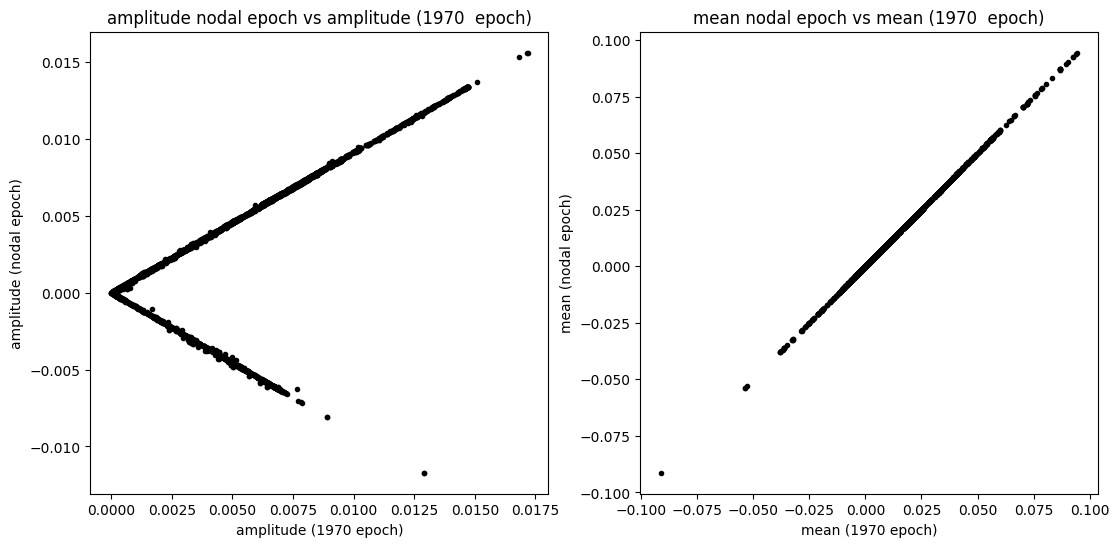

In [26]:
# The amplitude should be independent of the epoch. This should be a straight line
fig, axes = plt.subplots(ncols=2, figsize=(13, 6))

axes[0].plot(amplitude, amplitude_nodal_epoch, "k.")
axes[0].set_title("amplitude nodal epoch vs amplitude (1970  epoch)")
axes[0].set_xlabel("amplitude (1970 epoch)")
axes[0].set_ylabel("amplitude (nodal epoch)")

axes[1].plot(mean, mean_nodal_epoch, "k.")
axes[1].set_title("mean nodal epoch vs mean (1970  epoch)")
axes[1].set_xlabel("mean (1970 epoch)")
axes[1].set_ylabel("mean (nodal epoch)")

## Nodal amplitude and phase maps
This map is the nodal cycle phase. This map probably shows a strong correlation with the [equilibrium](https://www.researchgate.net/profile/Phajm_Gelder/publication/236019217_The_Effect_of_the_186-Year_Lunar_Nodal_Cycle_on_Regional_Sea-Level_Rise_Estimates/links/0deec533fc3c070917000000/The-Effect-of-the-186-Year-Lunar-Nodal-Cycle-on-Regional-Sea-Level-Rise-Estimates.pdf) (figure 4c) tide. Points are scaled with their amplitude so you don't see colors for points without nodal tide, where the phase is random. 

>> reading coastlines: 1.77 sec


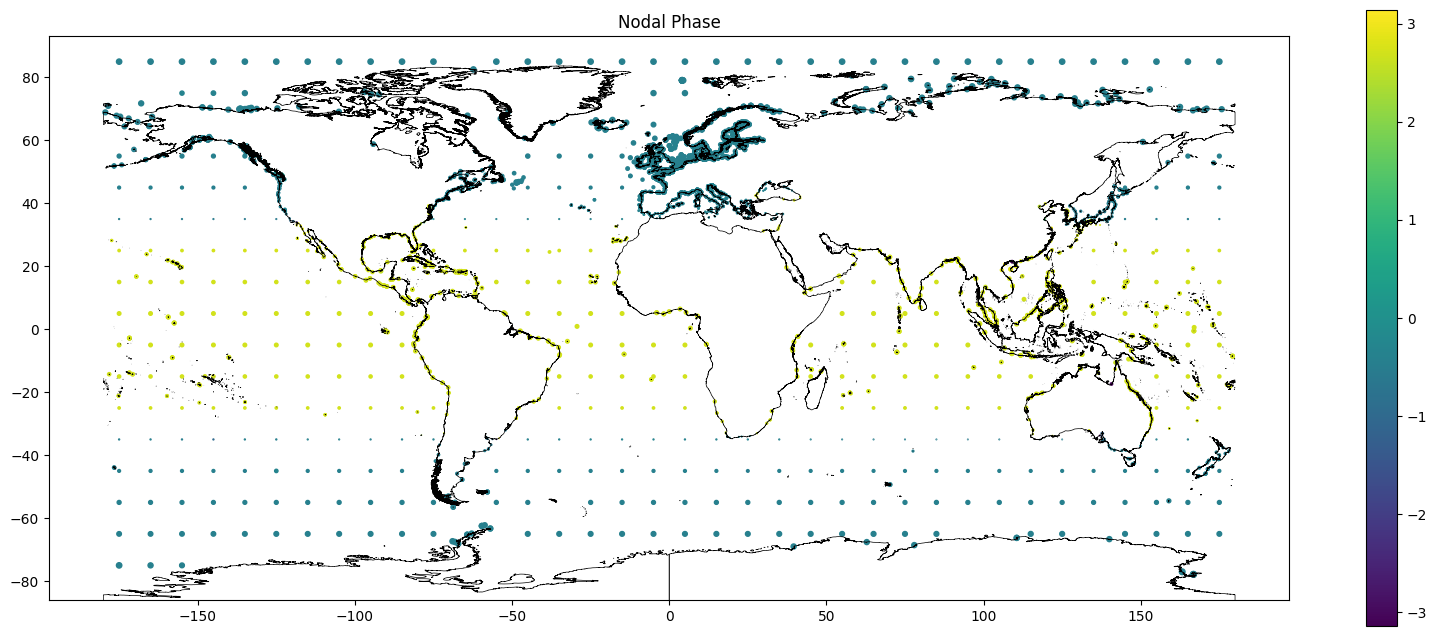

In [27]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.set_title("Nodal Phase")
sc = ax.scatter(
    x=ds_yearstats.station_x_coordinate.values,
    y=ds_yearstats.station_y_coordinate.values,
    c=phase,
    #cmap=cmcrameri.cm.romaO,
    vmin=-np.pi,
    vmax=np.pi,
    s=amplitude * 1000,
)
plt.colorbar(sc, ax=ax)
dfmt.plot_coastlines(ax=ax)

The map below is the nodal cycle amplitude. You expect to see higher amplitude at the equator and higher towards the higher latitudes.

>> reading coastlines: 1.81 sec


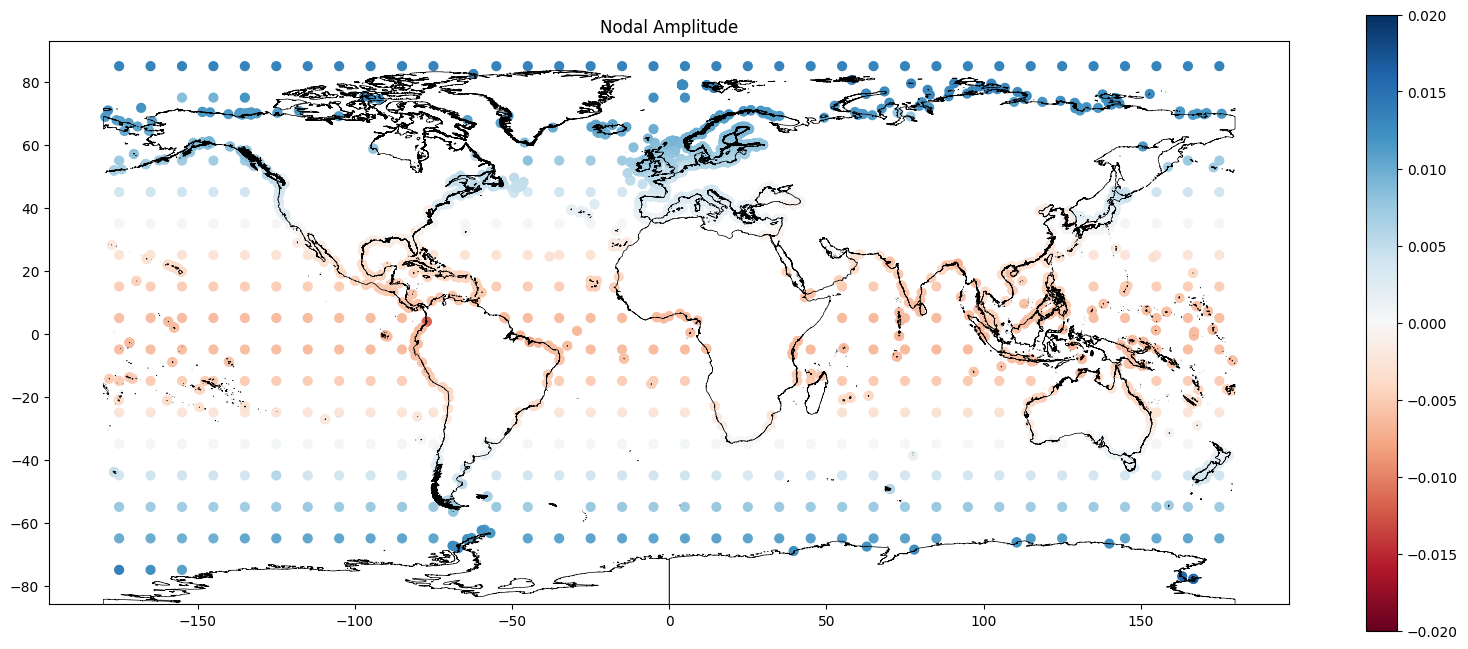

In [28]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.set_title("Nodal Amplitude")
# im = ax.scatter(lon, lat,  c=amplitude, cmap=cmcrameri.cm.tokyo_r, vmin=0, vmax=0.02, s=3, label='amplitude')
im = ax.scatter(
    x=ds_yearstats.station_x_coordinate.values,
    y=ds_yearstats.station_y_coordinate.values,
    c=amplitude_nodal_epoch,
    cmap="RdBu",
    vmin=-0.02,
    vmax=0.02,
    s=40,
    label="amplitude",
)
plt.colorbar(im, ax=ax)
dfmt.plot_coastlines(ax=ax)

## Amplitude and phase as a function of latitude
The figures below show the amplitude and phase as a function of latitude. This should be a squared sine function (or something like that) and a dichotomous phase plot, where the equator is in opposite phase. The analytical amplitude is shown in red (see [Woodworth 2012](https://bioone.org/journals/journal-of-coastal-research/volume-28/issue-2/JCOASTRES-D-11A-00023.1/A-Note-on-the-Nodal-Tide-in-Sea-Level-Records/10.2112/JCOASTRES-D-11A-00023.1.full)).

The GTSM-derived nodal tide characteristics largely agree with the analytical formulation. Notably we see a few points that are in the opposite phase from equilibrium, and also some outliers for amplitude. This can be investigated further - it is possible that these data points are not accurate because of the model schematization. 

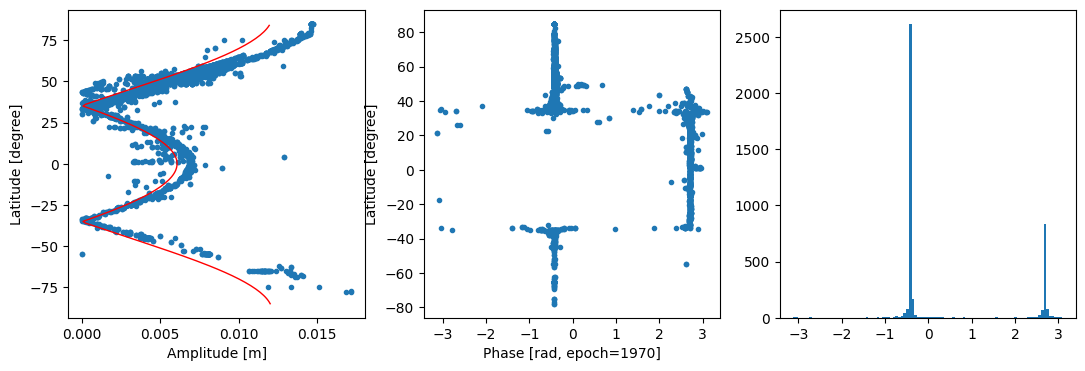

In [29]:
fig, axes = plt.subplots(ncols=3, figsize=(13, 4))
axes[0].plot(amplitude, ds_yearstats.station_y_coordinate.values, ".")
axes[0].set_xlabel("Amplitude [m]")
axes[0].set_ylabel("Latitude [degree]")
axes[1].plot(phase, ds_yearstats.station_y_coordinate.values, ".")
axes[1].set_xlabel("Phase [rad, epoch=1970]")
axes[1].set_ylabel("Latitude [degree]")
axes[2].hist(phase, bins=100)

lat_analytic_clean = np.arange(-85, 85, 1)
#amp_analytic_clean = (np.abs(0.69 * 20 * (3 * np.sin(np.deg2rad(lat_analytic_clean)) ** 2 - 1)) / 1000)
amp_analytic_clean = (np.abs(0.69 * 17.6 * (1.5 * np.sin(np.deg2rad(lat_analytic_clean)) ** 2 - 0.5)) / 1000)
axes[0].plot(amp_analytic_clean, lat_analytic_clean, "r-", linewidth=1)
#amp_analytic = np.abs(0.69 * 20 * (3 * np.sin(np.deg2rad(lat)) ** 2 - 1)) / 1000

We can compare the GTSM-derived nodal amplitude with the analytically-derived amplitude by plotting the relative values on a global map:

In [55]:
amp_analytical = (np.abs(0.69 * 17.6 * (1.5 * np.sin(np.deg2rad(ds_yearstats.station_y_coordinate.values)) ** 2 - 0.5)) / 1000)

amplitude_relative = amplitude / amp_analytical

>> reading coastlines: 2.05 sec


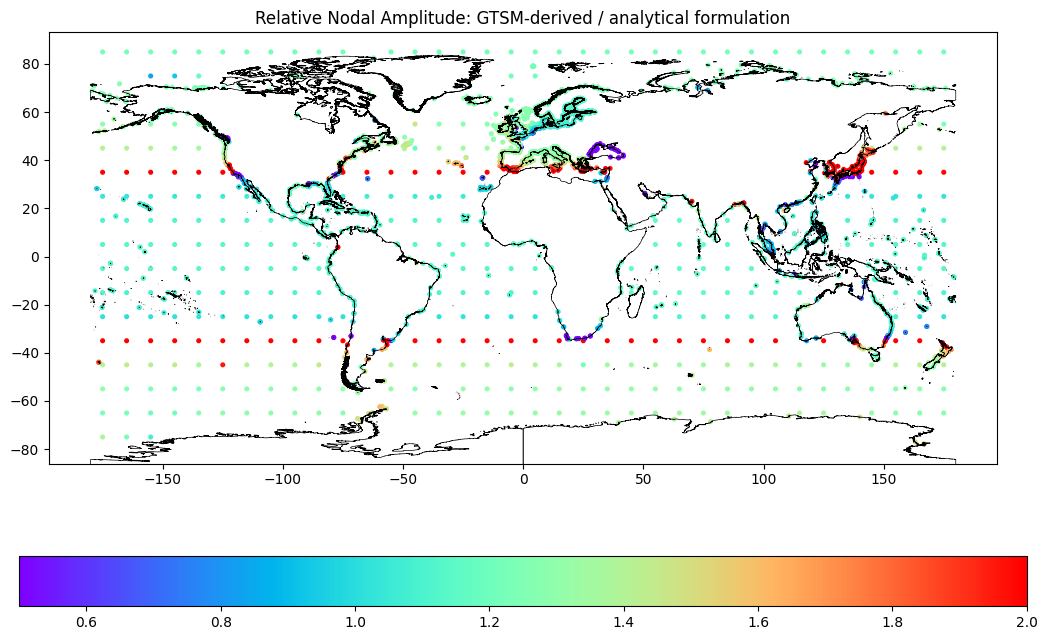

In [57]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.set_title("Relative Nodal Amplitude: GTSM-derived / analytical formulation")
im = ax.scatter(
    ds_yearstats.station_x_coordinate.values,
    ds_yearstats.station_y_coordinate.values,
    c=amplitude_relative,
    cmap="rainbow",
    vmin=0.5,
    vmax=2,
    s=7,
    label="relative amplitude",
)
plt.colorbar(im, ax=ax, orientation='horizontal')
dfmt.plot_coastlines(ax=ax)

## Creating overview dataset for all stations

In [40]:
ds_nodaltide = ds_yearstats.drop_dims("time")
ds_nodaltide

<xarray.Dataset> Size: 788kB
Dimensions:               (stations: 4104)
Coordinates:
    station_x_coordinate  (stations) float64 33kB -155.0 -145.0 ... 16.96 11.83
    station_y_coordinate  (stations) float64 33kB 75.0 75.0 75.0 ... 58.48 58.15
  * stations              (stations) int64 33kB 0 1 2 3 ... 4200 4201 4202 4203
    station_name          (stations) <U40 657kB 'arctic_ocean_xm155_y75' ... ...
Data variables:
    bedlevel              (stations) float64 33kB -4.24e+03 ... -18.64
Attributes:
    CDI:            Climate Data Interface version 1.9.5 (http://mpimet.mpg.d...
    Conventions:    CF-1.5 Deltares-0.1
    history:        Tue Mar 23 13:04:21 2021: cdo -L -yearmean -selyear,1999 ...
    source:         Deltares, D-Flow FM Version 1.2.104.67831M, Oct 28 2020, ...
    institution:    Deltares
    references:     http://www.deltares.nl
    date_created:   2021-03-15T13:17:56+0100
    date_modified:  2021-03-15T13:17:56+0100
    frequency:      year
    CDO:            Climate Data Operators version 1.9.5 (http://mpimet.mpg.d...

In [ ]:
ds_nodaltide = ds_nodaltide.assign(mean_waterlevel=('stations', ds_yearstats['waterlevel_mean'].mean("time").values))
ds_nodaltide['mean_waterlevel'].attrs = {'description': 'mean waterlevel from GTSM over 1999-2017',
                                         'units' : 'm'} 

ds_nodaltide = ds_nodaltide.assign(amplitude=('stations', amplitude))
ds_nodaltide['amplitude'].attrs = {'description': 'Nodal tide amplitude fitted based on GTSM tidal timeseries over 1999-2017',
                                   'units' : 'm'}

ds_nodaltide = ds_nodaltide.assign(phase=('stations', phase))
ds_nodaltide['phase'].attrs = {'description': 'Nodal tide phase fitted based on GTSM tidal timeseries over 1999-2017',
                                   'units' : 'radian'}

ds_nodaltide = ds_nodaltide.assign(mean=('stations', mean))
ds_nodaltide['mean'].attrs = {'description': 'Mean resulting from fitting nodal tide based on GTSM tidal timeseries over 1999-2017',
                                   'units' : 'm'}

ds_nodaltide = ds_nodaltide.assign(A=('stations', A))
ds_nodaltide['A'].attrs = {'description': 'Linear regression fit coefficient A',
                                   'units' : ''}
ds_nodaltide = ds_nodaltide.assign(B=('stations', B))
ds_nodaltide['B'].attrs = {'description': 'Linear regression fit coefficient B',
                                   'units' : ''}
ds_nodaltide = ds_nodaltide.assign(amp_analytical=('stations', amp_analytical))

In [42]:
ds_nodaltide

<xarray.Dataset> Size: 1MB
Dimensions:               (stations: 4104)
Coordinates:
    station_x_coordinate  (stations) float64 33kB -155.0 -145.0 ... 16.96 11.83
    station_y_coordinate  (stations) float64 33kB 75.0 75.0 75.0 ... 58.48 58.15
  * stations              (stations) int64 33kB 0 1 2 3 ... 4200 4201 4202 4203
    station_name          (stations) <U40 657kB 'arctic_ocean_xm155_y75' ... ...
Data variables:
    bedlevel              (stations) float64 33kB -4.24e+03 ... -18.64
    mean_waterlevel       (stations) float64 33kB -0.01906 -0.009774 ... 0.01912
    amplitude             (stations) float64 33kB 0.009091 0.01019 ... 0.008399
    phase                 (stations) float64 33kB -0.3349 -0.3644 ... -0.4206
    mean                  (stations) float64 33kB -0.019 -0.009672 ... 0.01926
    A                     (stations) float64 33kB 0.008586 0.009517 ... 0.007667
    B                     (stations) float64 33kB -0.002988 ... -0.003429
    amp_analytical        (stations) float64 33kB 0.01092 0.01092 ... 0.007071
Attributes:
    CDI:            Climate Data Interface version 1.9.5 (http://mpimet.mpg.d...
    Conventions:    CF-1.5 Deltares-0.1
    history:        Tue Mar 23 13:04:21 2021: cdo -L -yearmean -selyear,1999 ...
    source:         Deltares, D-Flow FM Version 1.2.104.67831M, Oct 28 2020, ...
    institution:    Deltares
    references:     http://www.deltares.nl
    date_created:   2021-03-15T13:17:56+0100
    date_modified:  2021-03-15T13:17:56+0100
    frequency:      year
    CDO:            Climate Data Operators version 1.9.5 (http://mpimet.mpg.d...

In [43]:
ds_nodaltide.to_netcdf("gtsm_nodal_tide_1999-2017_all_stations.nc")

## Nodal tide at the Dutch coast based on GTSM

To inspect the nodal tide values at the Dutch coast more closely, we will subset the full dataset to a bounding box around the Netherlands (can be adjusted below to include other areas):

In [45]:
ds_nodaltide_nl = ds_nodaltide.where((ds_nodaltide.station_x_coordinate < 7.22) & 
                                     (ds_nodaltide.station_x_coordinate > 2) & 
                                     (ds_nodaltide.station_y_coordinate < 54.5) & 
                                     (ds_nodaltide.station_y_coordinate > 51.2), drop=True)
ds_nodaltide_nl

<xarray.Dataset> Size: 49kB
Dimensions:               (stations: 198)
Coordinates:
    station_x_coordinate  (stations) float64 2kB 2.007 6.746 ... 6.746 3.684
    station_y_coordinate  (stations) float64 2kB 51.4 53.55 ... 53.55 51.61
  * stations              (stations) int64 2kB 1058 1084 1090 ... 3013 3421 3737
    station_name          (stations) <U40 32kB 'IBIS_GL_TS_MO_62170' ... 'psm...
Data variables:
    bedlevel              (stations) float64 2kB -41.4 -11.47 ... -11.47 -25.66
    mean_waterlevel       (stations) float64 2kB 0.03161 0.03866 ... 0.04693
    amplitude             (stations) float64 2kB 0.005204 0.005793 ... 0.004179
    phase                 (stations) float64 2kB -0.4006 -0.4161 ... -0.4049
    mean                  (stations) float64 2kB 0.03165 0.03875 ... 0.04697
    A                     (stations) float64 2kB 0.004792 0.005299 ... 0.003841
    B                     (stations) float64 2kB -0.002029 ... -0.001646
    amp_analytical        (stations) float64 2kB 0.005054 0.005713 ... 0.00512
Attributes:
    CDI:            Climate Data Interface version 1.9.5 (http://mpimet.mpg.d...
    Conventions:    CF-1.5 Deltares-0.1
    history:        Tue Mar 23 13:04:21 2021: cdo -L -yearmean -selyear,1999 ...
    source:         Deltares, D-Flow FM Version 1.2.104.67831M, Oct 28 2020, ...
    institution:    Deltares
    references:     http://www.deltares.nl
    date_created:   2021-03-15T13:17:56+0100
    date_modified:  2021-03-15T13:17:56+0100
    frequency:      year
    CDO:            Climate Data Operators version 1.9.5 (http://mpimet.mpg.d...

We can check where this data is situated on the plot of amplitude and phase as a function of latitude:

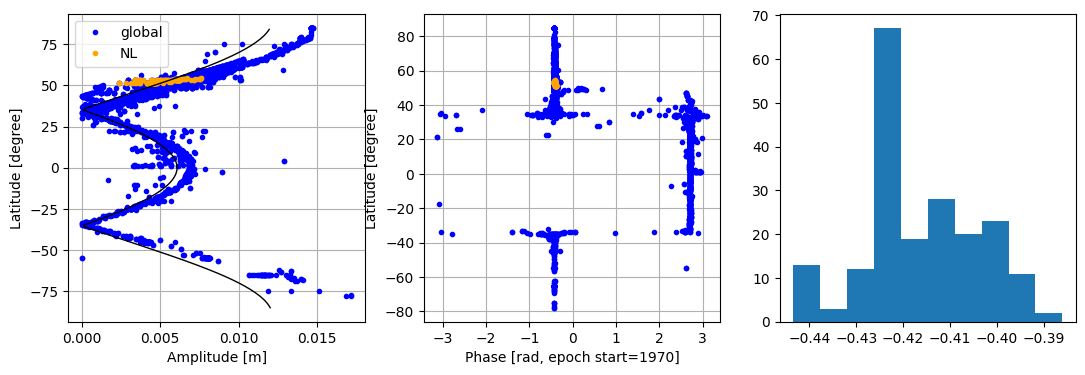

In [62]:
fig, axes = plt.subplots(ncols=3, figsize=(13, 4))

axes[0].plot(ds_nodaltide.amplitude, ds_nodaltide.station_y_coordinate, ".", label='global', color='blue')
axes[0].plot(ds_nodaltide_nl.amplitude, ds_nodaltide_nl.station_y_coordinate, ".", label='NL', color='orange')
axes[0].set_xlabel("Amplitude [m]")
axes[0].set_ylabel("Latitude [degree]")
axes[1].plot(ds_nodaltide.phase, ds_nodaltide.station_y_coordinate, ".", color='blue')
axes[1].plot(ds_nodaltide_nl.phase, ds_nodaltide_nl.station_y_coordinate, ".", color='orange')
axes[1].set_xlabel("Phase [rad, epoch start=1970]")
axes[1].set_ylabel("Latitude [degree]")
axes[2].hist(ds_nodaltide_nl.phase, bins=10)
axes[0].legend()
axes[0].grid()
axes[1].grid()

axes[0].plot(amp_analytic_clean, lat_analytic_clean, "k-", linewidth=1, label='analytical')

We can also plot the nodal tide amplitude on a map to check spatial variation:

>> reading coastlines: 1.18 sec


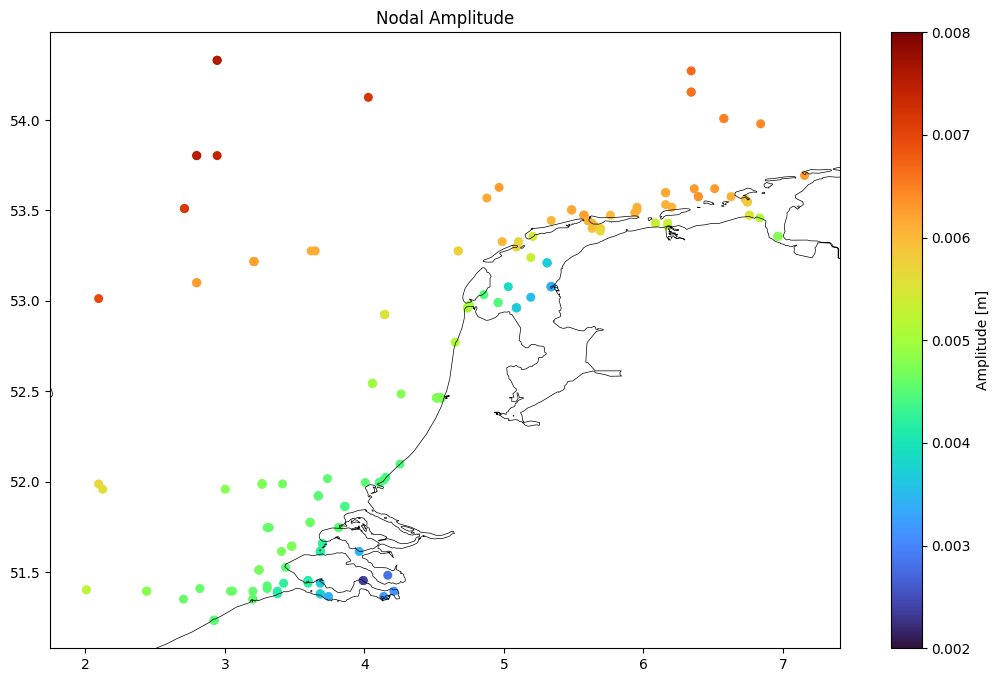

In [63]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.set_title("Nodal Amplitude")
im = ax.scatter(
    ds_nodaltide_nl.station_x_coordinate.values,
    ds_nodaltide_nl.station_y_coordinate.values,
    c=ds_nodaltide_nl.amplitude,
    cmap="turbo",
    vmin=0.002,
    vmax=0.008,
    s=30,
    label="amplitude",
)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Amplitude [m]')
dfmt.plot_coastlines(ax=ax)

To compare the GTSM-derived nodal amplitude with the analytically-derived amplitude (based on latitude), we can plot the relative values below. What this plot demonstrates is that nodal amplitudes derived from GTSM are approximately equal to the analytical equilibrium values just offshore from the coast. Lower amplitudes are derived for estuaries and in the Wadden Sea, and higher values are calculated further offshore in the North Sea.

>> reading coastlines: 0.95 sec


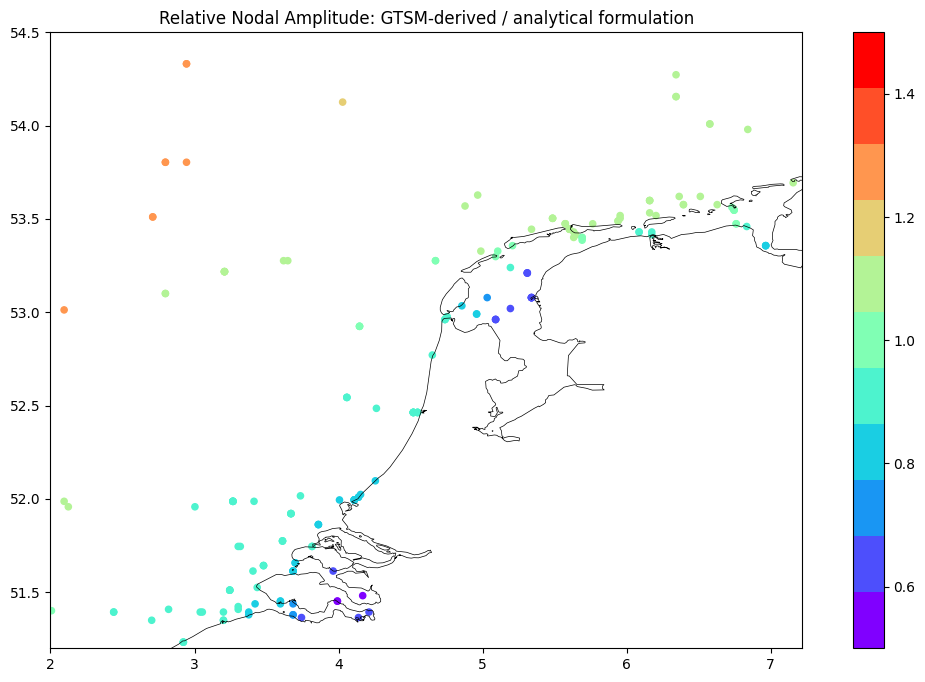

In [64]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.set_title("Relative Nodal Amplitude: GTSM-derived / analytical formulation")
# im = ax.scatter(lon, lat,  c=amplitude, cmap=cmcrameri.cm.tokyo_r, vmin=0, vmax=0.02, s=3, label='amplitude')
im = ax.scatter(
    ds_nodaltide_nl.station_x_coordinate.values,
    ds_nodaltide_nl.station_y_coordinate.values,
    c=ds_nodaltide_nl.amplitude.values / ds_nodaltide_nl.amp_analytical.values,
    cmap=plt.get_cmap("rainbow", 11) ,
    vmin=0.5,
    vmax=1.5,
    s=20,
    label="relative amplitude",
)
plt.colorbar(im, ax=ax)
ax.set_xlim([2, 7.22])
ax.set_ylim([51.2, 54.5])
dfmt.plot_coastlines(ax=ax)

We will save the dataset of nodal tide parameters in the Netherlands derived from GTSM:

In [65]:
ds_nodaltide_nl.to_netcdf("nodal_tide_from_GTSM/gtsm_nodal_tide_1999-2017_NL_stations.nc")

In [66]:
ds_nodaltide_nl

<xarray.Dataset> Size: 49kB
Dimensions:               (stations: 198)
Coordinates:
    station_x_coordinate  (stations) float64 2kB 2.007 6.746 ... 6.746 3.684
    station_y_coordinate  (stations) float64 2kB 51.4 53.55 ... 53.55 51.61
  * stations              (stations) int64 2kB 1058 1084 1090 ... 3013 3421 3737
    station_name          (stations) <U40 32kB 'IBIS_GL_TS_MO_62170' ... 'psm...
Data variables:
    bedlevel              (stations) float64 2kB -41.4 -11.47 ... -11.47 -25.66
    mean_waterlevel       (stations) float64 2kB 0.03161 0.03866 ... 0.04693
    amplitude             (stations) float64 2kB 0.005204 0.005793 ... 0.004179
    phase                 (stations) float64 2kB -0.4006 -0.4161 ... -0.4049
    mean                  (stations) float64 2kB 0.03165 0.03875 ... 0.04697
    A                     (stations) float64 2kB 0.004792 0.005299 ... 0.003841
    B                     (stations) float64 2kB -0.002029 ... -0.001646
    amp_analytical        (stations) float64 2kB 0.005054 0.005713 ... 0.00512
Attributes:
    CDI:            Climate Data Interface version 1.9.5 (http://mpimet.mpg.d...
    Conventions:    CF-1.5 Deltares-0.1
    history:        Tue Mar 23 13:04:21 2021: cdo -L -yearmean -selyear,1999 ...
    source:         Deltares, D-Flow FM Version 1.2.104.67831M, Oct 28 2020, ...
    institution:    Deltares
    references:     http://www.deltares.nl
    date_created:   2021-03-15T13:17:56+0100
    date_modified:  2021-03-15T13:17:56+0100
    frequency:      year
    CDO:            Climate Data Operators version 1.9.5 (http://mpimet.mpg.d...